In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import numpy as np
import json

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
NUM_CLASSES = 102

## Load Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = '../Datasets/Kaggle/flower-data'
# A map with keys "train" and "val" and values being images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# A map with keys "train" and "val" and values being DataLoaders. A DataLoader is an iterable. 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize data

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

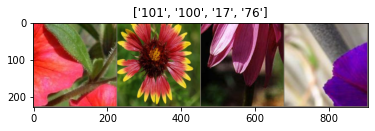

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch for the visualization purposes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Test

In [28]:
inputs, classes = next(iter(dataloaders["train"]))
print(classes)

tensor([ 0, 12,  5, 17])


## Train the model

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            for inputs, labels in tqdm(dataloaders[phase]):
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    print(labels.shape)
                    print(labels)
                    print(outputs.shape)
                    print("\n\n")

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize the model predictions

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, label: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetune the ResNet18

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

num_classes = 102
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [5]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

NameError: name 'train_model' is not defined

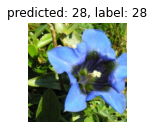

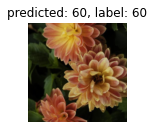

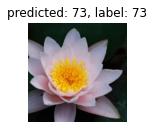

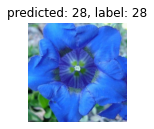

In [22]:
visualize_model(model_ft, 4)

## Save Model

In [43]:
model_path = "saved-models/baseline1.pth"
torch.save(model_ft.state_dict(), "saved-models/baseline1.pth")

## Load Model

In [18]:
model_path = "saved-models/baseline_resnet18_10epochs.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Error Analysis

In [19]:
index_to_name_map = {}
with open("../Datasets/Kaggle/flower-data/index_to_name.json") as json_file:
    index_to_name_map = json.load(json_file)
ordered_flower_names = []
for key in sorted(index_to_name_map.keys()):
    ordered_flower_names.append(index_to_name_map[key])

In [20]:
# Make a matrix whose row represents true labels and column represents prediction labels
def create_prediction_matrix(model, dataset, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0

    prediction_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES)).astype(int)

    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[dataset])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Iterate through predictions for one batch
            for j in range(inputs.size()[0]):
                prediction_matrix[labels[j]][preds[j]] += 1        
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return prediction_matrix
        model.train(mode=was_training)
        return prediction_matrix

In [21]:
prediction_matrix = create_prediction_matrix(model_ft, 'val', 900)

205it [00:06, 34.15it/s]


In [22]:
def normalize_prediciton_matrix(prediction_matrix):
    normalized_prediction_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for j in range(NUM_CLASSES):
        column_sum = np.sum(prediction_matrix[:, j])
        if column_sum != 0:
            normalized_prediction_matrix[:, j] = prediction_matrix[:, j] / column_sum
    return np.around(normalized_prediction_matrix, decimals=1)

In [52]:
def visualize_matrix(matrix):
    plt.figure(figsize = (100, 100))
    plt.rcParams['figure.figsize'] = (30, 30)
    plt.matshow(matrix)
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.title("Prediction Results", fontsize=24)
    plt.xticks(ticks=np.arange(0, 102), labels=ordered_flower_names, rotation="vertical", fontsize=12)
    plt.yticks(ticks=np.arange(0, 102), labels=ordered_flower_names, fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("bottom")
    
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if matrix[i, j] != 0:
                text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="w")
    plt.show()

<Figure size 7200x7200 with 0 Axes>

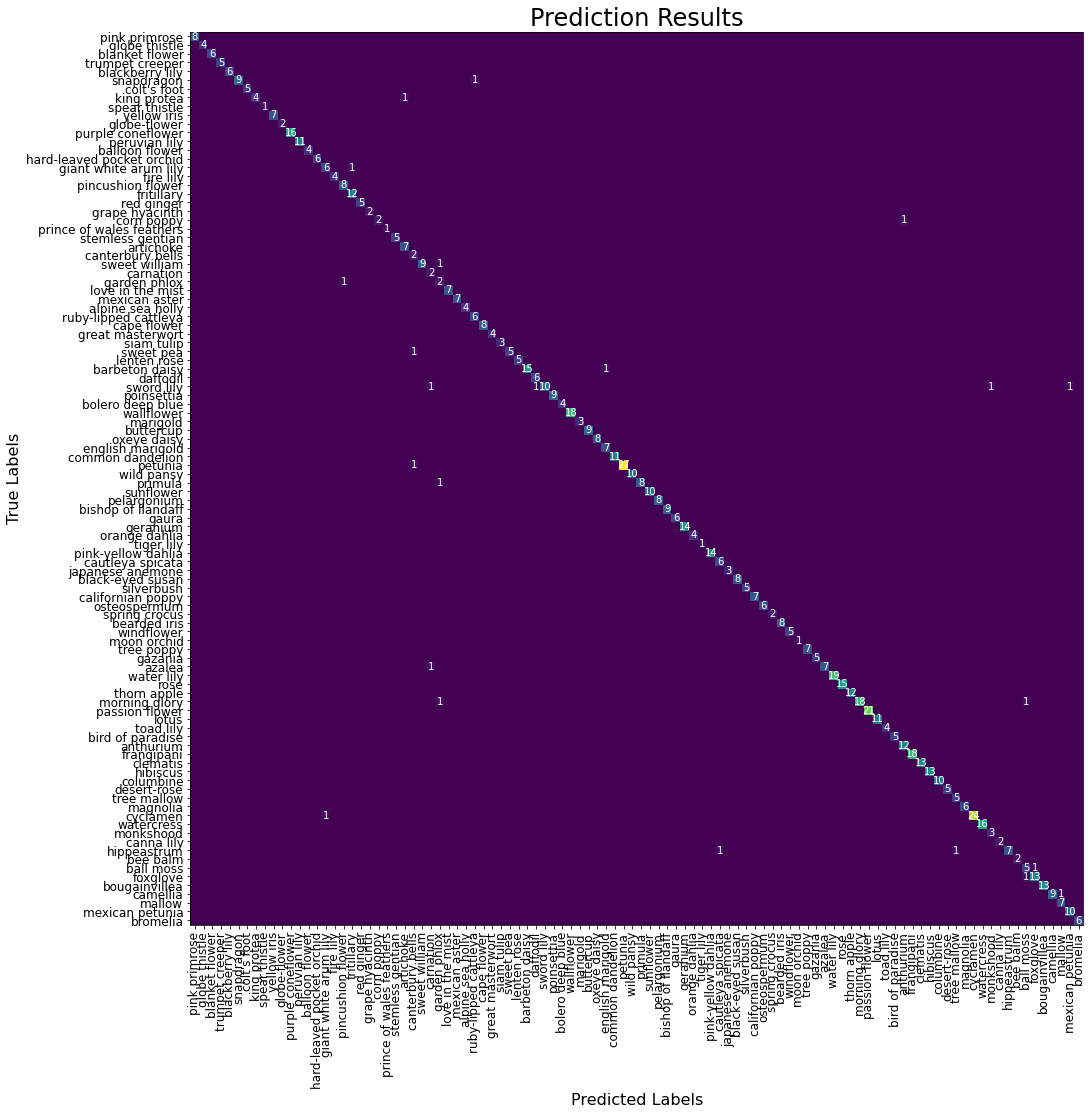

In [53]:
visualize_matrix(prediction_matrix)

<Figure size 7200x7200 with 0 Axes>

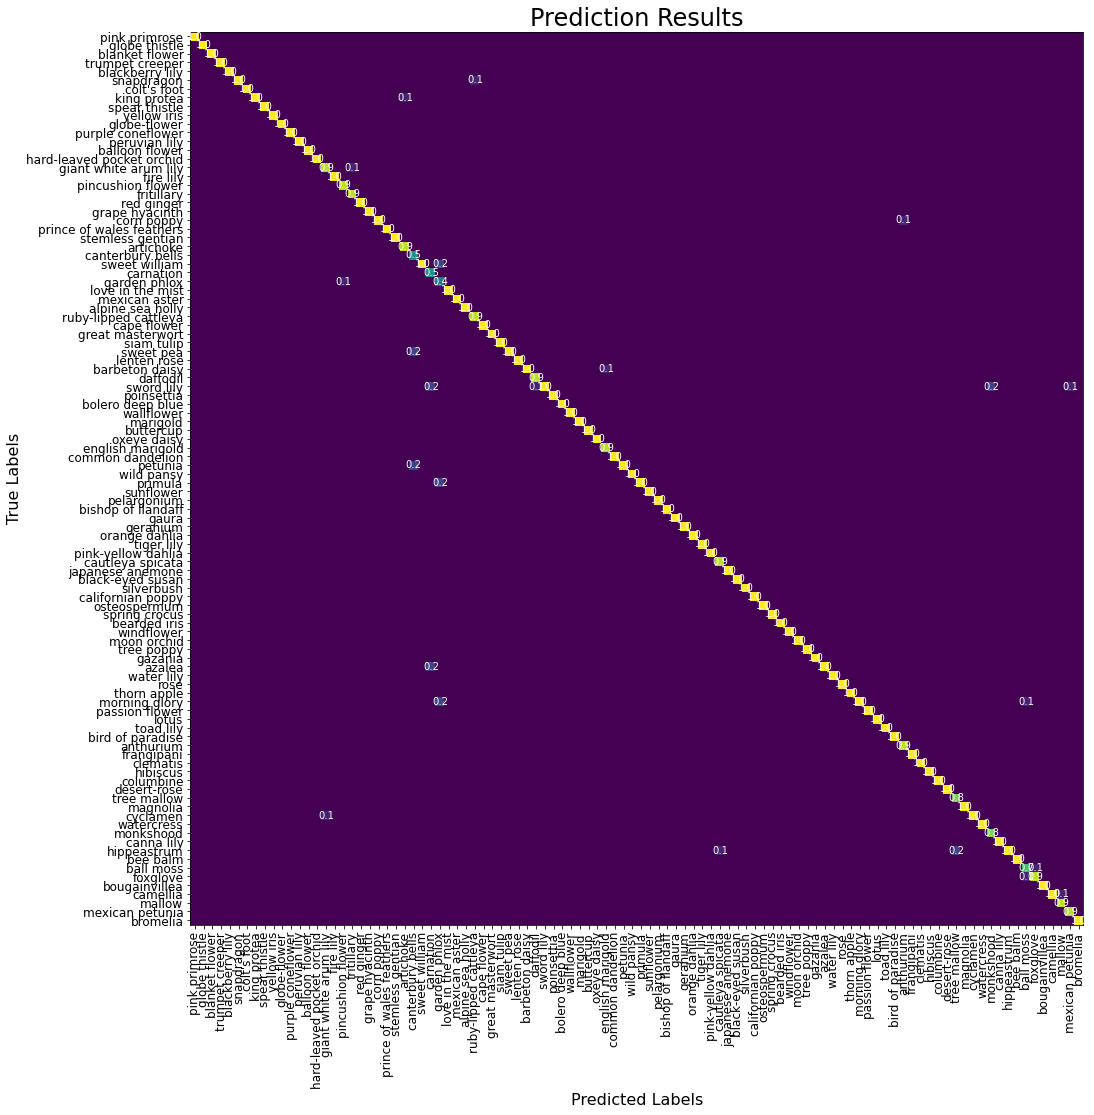

In [54]:
visualize_matrix(normalize_prediciton_matrix(prediction_matrix))

In [ ]:
def visualize_matrix(matrix):
    figure = plt.figure(figsize = (100, 100))
    ax = plt.gca()
    
    plt.rcParams['figure.figsize'] = (30, 30)
    im = ax.matshow(matrix)
    figure.colorbar(im)
    ax.set_xticklabels("Predicted Labels", fontsize=64)
    ax.set_yticklabels("True Labels", fontsize=64)
    ax.set_title("Prediction Results", fontsize=24)
    ax.set_xticks(ticks=np.arange(0, 102), labels=ordered_flower_names, rotation="vertical", fontsize=12)
    ax.set_yticks(ticks=np.arange(0, 102), labels=ordered_flower_names, fontsize=12)
    ax.xaxis.set_ticks_position("bottom")
    
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if matrix[i, j] != 0:
                text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="w")
    plt.show()